In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import plot_time_series, plot_map
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import math
import os

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)

AttributeError: `np.round_` was removed in the NumPy 2.0 release. Use `np.round` instead.

In [2]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"
wow_file = ucl_dir + "wow_BE.csv"
orig_data = pd.read_csv(wow_file)


/tmp/ipykernel_1965728/2817448540.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_data = pd.read_csv(wow_file)


In [3]:
wow_data = orig_data[["Id", "Longitude", "Latitude", "Report Date / Time", "Air Temperature"]]
wow_data = wow_data.rename(columns = {"Air Temperature" : "T2", "Report Date / Time": "time", "Longitude":"lon", "Latitude": "lat"})

In [4]:
wow_data["location"] = wow_data["lat"].astype(str) + '-' + wow_data["lon"].astype(str)

In [ ]:
d_coord_points = wow_data[["location", "lat", "lon"]]
d_coord_points = d_coord_points.drop_duplicates().reset_index(drop = True)
d_coord_points.to_csv(ucl_dir + 'WOW_data_locations.csv')

In [6]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def plot_points_map(d_coord_points, region, bounds, scale_var=None, lat_name = "lat", lon_name = "lon", station_id = "code", add_labels = False): 
    """
    Plots a map with points and an optional colorbar.
    
    Parameters:
    - d_coord_points (pd.DataFrame): DataFrame containing 'lon', 'lat', 'code', and optionally scale_var.
    - region (str): The region to display.
    - bounds (dict): Dictionary containing lat/lon bounds for regions.
    - scale_var (str, optional): Column name for variable used to scale colors.
    """
    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Handle scaling variable
    if scale_var:
        cmap = plt.cm.Reds
        norm = Normalize(vmin=d_coord_points[scale_var].min(), vmax=d_coord_points[scale_var].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create a ScalarMappable for the colorbar
        sm.set_array([])  # ScalarMappable requires a linked array but it won't be used here

    # Plot each point and add a label
    for i in np.arange(0, len(d_coord_points)):
        lon = d_coord_points.loc[i, lon_name]
        lat = d_coord_points.loc[i, lat_name]
        key = d_coord_points.loc[i, station_id]

        if scale_var:
            var_value = d_coord_points.loc[i, scale_var]
            code_color = cmap(norm(var_value))
            ax.scatter(lon, lat, edgecolor='black', s=50, c=[code_color], transform=ccrs.PlateCarree())
        else:
            ax.scatter(lon, lat, color='red', s=50, transform=ccrs.PlateCarree())
        
        # Add text labels
        if add_labels:
            ax.text(lon + 0.05, lat - 0.05, key, transform=ccrs.PlateCarree())

    # Set extent based on bounds
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    # Add colorbar if scale_var is provided
    if scale_var:
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
        cbar.set_label(f'{scale_var.capitalize()}')

    # Add a title
    ax.set_title('Location of Points', loc='right')

    # Show the plot
    plt.show()


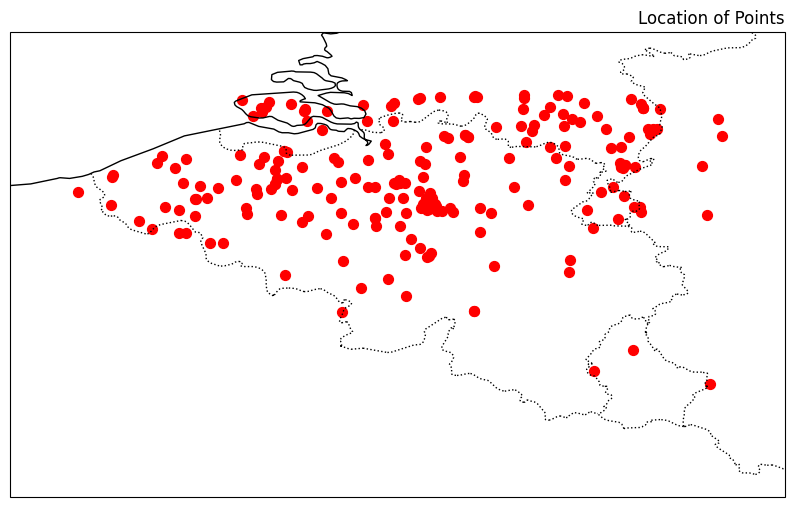

In [ ]:
plot_points_map(d_coord_points, "belgium", bounds, station_id = "location")

## Averaging observations within WRF gridcell

In [ ]:
file_domain3 = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/geo_em.d03_new.nc"
ds = xr.open_mfdataset(file_domain3, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})
da = ds["LU_INDEX"]

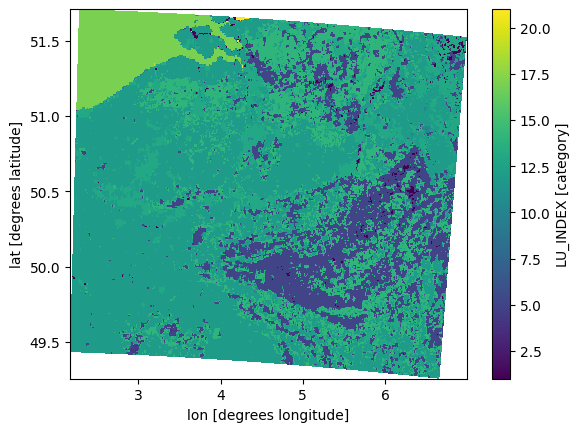

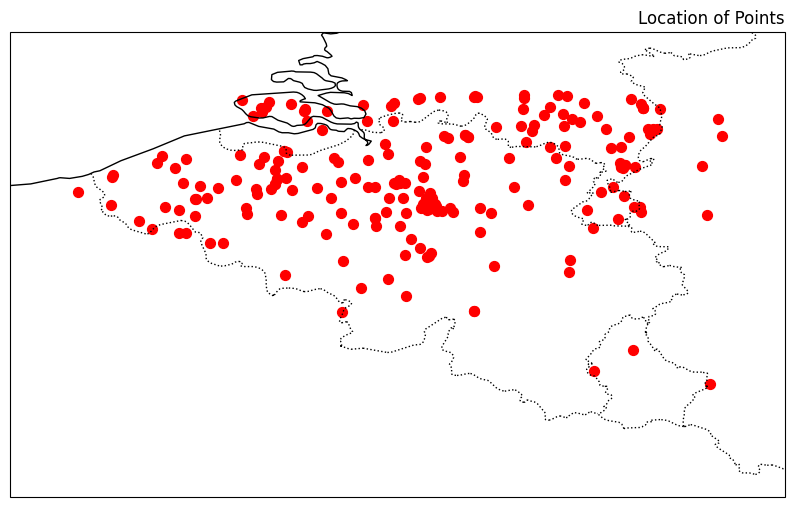

In [ ]:
da.plot(x = "lon", y = "lat")
plot_points_map(d_coord_points, "belgium", bounds, station_id = "location")